## import

In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
from torchmetrics.classification import jaccard
import albumentations as A
import torch
import torch.nn.functional as F
import torchinfo
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils.data import DataLoader
from torchlake.common.constants import VOC_CLASS_NAMES
from torchlake.common.utils.convert import img_tensor_to_np
from torchlake.common.utils.image import decode_segmap, load_image
from torchlake.common.utils.plot import plot_grids
from torchlake.common.controller.trainer import ClassificationTrainer
from torchlake.common.controller.evaluator import ClassificationEvaluator
from torchlake.common.controller.weight_manager import WeightManager
from torchlake.common.utils.platform import get_file_size
from torchlake.common.datasets.voc import VOCSegmentation
from torchlake.common.datasets.voc.constants import LABEL_COLORS
from torchlake.semantic_segmentation.models.fcn import FCN, fcn_style_vgg
from tqdm import tqdm

d:\research\pytorch-implementations\gits\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# setting

In [2]:
artifacts_path = Path("../../artifacts/fcn")
artifacts_path.mkdir(exist_ok=True)

data_path = Path("../../data")

In [3]:
DEVICE = torch.device("cuda:0")

# data

In [4]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
NUM_CLASS = len(VOC_CLASS_NAMES)

In [5]:
preprocess = A.Compose(
    [
        A.HorizontalFlip(),
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

test_preprocess = A.Compose(
    [
        A.Resize(IMAGE_SIZE, IMAGE_SIZE),
        A.Normalize(0, 1), # in feature extractor
        ToTensorV2(),
    ]
)

In [6]:
train_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2012",
    transform=preprocess,
)

test_dataset = VOCSegmentation(
    data_path.as_posix(),
    year="2007",
    transform=test_preprocess,
)

In [7]:
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    drop_last=True,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
)

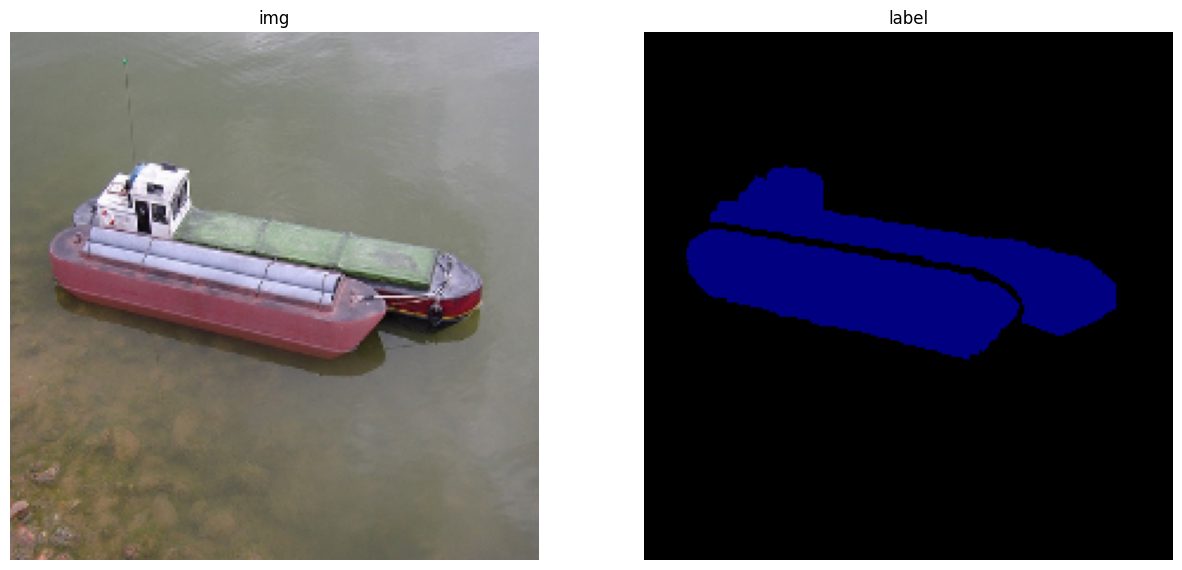

In [8]:
interest_pic = 102
img, label = train_dataset[interest_pic]

plot_grids(
    [
        img_tensor_to_np(img),
        decode_segmap(label, LABEL_COLORS),
    ],
    ["img", "label"],
    1,
    2,
    figsize=(15, 7),
)

# model

In [9]:
# for param count
backbone = fcn_style_vgg("vgg16", trainable=True, num_skip_connection=2)
model = FCN(backbone, NUM_CLASS + 1, num_skip_connection=2)

In [10]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
FCN                                      --
├─VGGFeatureExtractor: 1-1               --
│    └─Sequential: 2-1                   --
│    │    └─Conv2d: 3-1                  1,792
│    │    └─ReLU: 3-2                    --
│    │    └─Conv2d: 3-3                  36,928
│    │    └─ReLU: 3-4                    --
│    │    └─MaxPool2d: 3-5               --
│    │    └─Conv2d: 3-6                  73,856
│    │    └─ReLU: 3-7                    --
│    │    └─Conv2d: 3-8                  147,584
│    │    └─ReLU: 3-9                    --
│    │    └─MaxPool2d: 3-10              --
│    │    └─Conv2d: 3-11                 295,168
│    │    └─ReLU: 3-12                   --
│    │    └─Conv2d: 3-13                 590,080
│    │    └─ReLU: 3-14                   --
│    │    └─Conv2d: 3-15                 590,080
│    │    └─ReLU: 3-16                   --
│    │    └─MaxPool2d: 3-17              --
│    │    └─Conv2d: 3-18                

# train

## direct training

### FCN-16S

In [11]:
EPOCHS = 10

In [12]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [13]:
criterion = trainer.get_criterion(NUM_CLASS, reduction="sum")

In [15]:
backbone = fcn_style_vgg("vgg16", trainable=True, num_skip_connection=1)
model = FCN(backbone, NUM_CLASS + 1, num_skip_connection=1)

In [16]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, threshold=0.05, threshold_mode="rel")

In [17]:
# bilinear
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 364/364 [02:33<00:00,  2.37it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.2757e+04 (0.00%)


100%|██████████| 364/364 [02:21<00:00,  2.57it/s]


------------------------------------
Epoch 2
------------------------------------
total: 2.1866e+04 (-33.00%)


100%|██████████| 364/364 [02:25<00:00,  2.50it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.7707e+04 (-19.00%)


100%|██████████| 364/364 [02:29<00:00,  2.44it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.5984e+04 (-10.00%)


100%|██████████| 364/364 [02:33<00:00,  2.38it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.3544e+04 (-15.00%)


100%|██████████| 364/364 [02:59<00:00,  2.03it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.2618e+04 (-7.00%)


100%|██████████| 364/364 [03:00<00:00,  2.02it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.0708e+04 (-15.00%)


100%|██████████| 364/364 [03:02<00:00,  1.99it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.1270e+04 (5.00%)


100%|██████████| 364/364 [03:04<00:00,  1.98it/s]


------------------------------------
Epoch 9
------------------------------------
total: 8.6533e+03 (-23.00%)


100%|██████████| 364/364 [03:06<00:00,  1.96it/s]

------------------------------------
Epoch 10
------------------------------------
total: 7.8072e+03 (-10.00%)


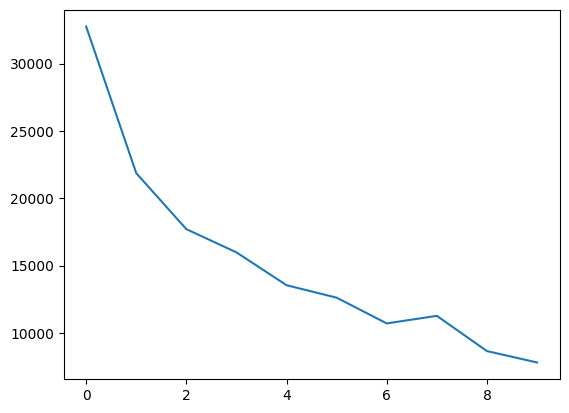

In [ ]:
plt.plot(training_loss)

In [ ]:
wm = WeightManager(artifacts_path.joinpath("fcn-16s.e2e.pth").as_posix())

In [ ]:
model_path = wm.get_filename()
model_path

In [ ]:
wm.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\fcn\fcn-16s.e2e.pth, model size is 514.3MiB


### FCN-8S

In [11]:
EPOCHS = 10

In [12]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [13]:
criterion = trainer.get_criterion(NUM_CLASS, reduction="sum")

In [14]:
backbone = fcn_style_vgg("vgg16", trainable=True, num_skip_connection=2)
model = FCN(backbone, NUM_CLASS + 1, num_skip_connection=2)

In [15]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, threshold=0.05, threshold_mode="rel")

In [16]:
training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 364/364 [02:33<00:00,  2.37it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.3805e+04 (0.00%)


100%|██████████| 364/364 [02:25<00:00,  2.50it/s]


------------------------------------
Epoch 2
------------------------------------
total: 2.1598e+04 (-36.00%)


100%|██████████| 364/364 [02:13<00:00,  2.73it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.8105e+04 (-16.00%)


100%|██████████| 364/364 [02:04<00:00,  2.92it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.5063e+04 (-17.00%)


100%|██████████| 364/364 [02:05<00:00,  2.90it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.2828e+04 (-15.00%)


100%|██████████| 364/364 [02:07<00:00,  2.86it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.1735e+04 (-9.00%)


100%|██████████| 364/364 [02:25<00:00,  2.50it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.0254e+04 (-13.00%)


100%|██████████| 364/364 [02:33<00:00,  2.37it/s]


------------------------------------
Epoch 8
------------------------------------
total: 9.7721e+03 (-5.00%)


100%|██████████| 364/364 [02:53<00:00,  2.10it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.0441e+04 (7.00%)


100%|██████████| 364/364 [02:56<00:00,  2.06it/s]

------------------------------------
Epoch 10
------------------------------------
total: 9.0805e+03 (-13.00%)


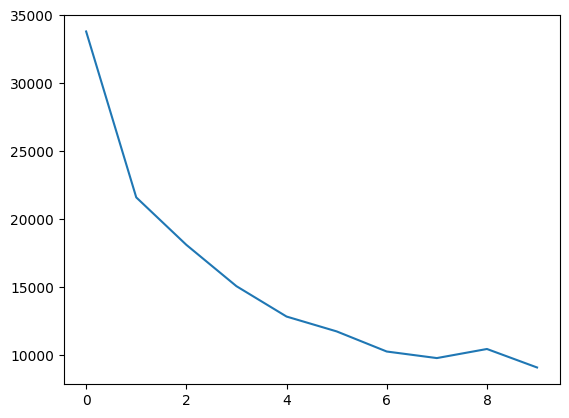

In [17]:
plt.plot(training_loss)

In [26]:
wm = WeightManager(artifacts_path.joinpath("fcn-8s.e2e.pth").as_posix())

In [27]:
model_path = wm.get_filename()
model_path

WindowsPath('../../artifacts/fcn/fcn-8s.e2e.pth')

In [28]:
wm.save_weight(model.state_dict(), model_path)

Save weight to ..\..\artifacts\fcn\fcn-8s.e2e.pth, model size is 513.05MiB


## multi-stage training

In [9]:
EPOCHS = 10

In [10]:
trainer = ClassificationTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [11]:
criterion = trainer.get_criterion(NUM_CLASS, reduction="sum")

In [12]:
# 0 => FCN-32s
# 1 => FCN-16s
# 2 => FCN-8s
NUM_SKIP_CONNECTION = 2

In [13]:
prev_model = None
for num_skip_connection in range(0, NUM_SKIP_CONNECTION+1):
    print(f"training FCN-{2**(5 - num_skip_connection)}s...")
    
    lr = [1e-4, 1e-4, 1e-4][num_skip_connection]
    
    backbone = fcn_style_vgg(
        "vgg16",
        trainable=True,
        num_skip_connection=num_skip_connection,
    )
    model = FCN(
        backbone,
        NUM_CLASS + 1,
        num_skip_connection=num_skip_connection,
    ).to(DEVICE)

    if num_skip_connection > 0:
        print("updating weights...")
        model.foot.load_state_dict(prev_model.foot.state_dict())
        model.blocks.load_state_dict(prev_model.blocks.state_dict(), strict=False)
        for i in range(1, num_skip_connection):
            model.head.pop(i)
            model.head.insert(i, prev_model.head.pop(i))
        print("updated weights")

    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, "min", patience=5, threshold=0.05, threshold_mode="rel")
    training_loss = trainer.run(train_loader, model, optimizer, criterion, scheduler)
    
    trainer.recorder.reset_epoch()
    # 8s check
    if num_skip_connection < 2:
        prev_model = model
        # for param in prev_model.parameters():
        #     param.requires_grad_(False)

training FCN-32s...
Enable AMP: False
Training...


100%|██████████| 364/364 [01:52<00:00,  3.25it/s]


------------------------------------
Epoch 1
------------------------------------
total: 3.6272e+04 (0.00%)


100%|██████████| 364/364 [01:52<00:00,  3.23it/s]


------------------------------------
Epoch 2
------------------------------------
total: 2.4306e+04 (-33.00%)


100%|██████████| 364/364 [02:02<00:00,  2.98it/s]


------------------------------------
Epoch 3
------------------------------------
total: 1.9515e+04 (-20.00%)


100%|██████████| 364/364 [02:19<00:00,  2.61it/s]


------------------------------------
Epoch 4
------------------------------------
total: 1.7335e+04 (-11.00%)


100%|██████████| 364/364 [01:59<00:00,  3.04it/s]


------------------------------------
Epoch 5
------------------------------------
total: 1.4731e+04 (-15.00%)


100%|██████████| 364/364 [01:47<00:00,  3.39it/s]


------------------------------------
Epoch 6
------------------------------------
total: 1.3607e+04 (-8.00%)


100%|██████████| 364/364 [01:46<00:00,  3.41it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.1740e+04 (-14.00%)


100%|██████████| 364/364 [01:47<00:00,  3.39it/s]


------------------------------------
Epoch 8
------------------------------------
total: 1.1978e+04 (2.00%)


100%|██████████| 364/364 [01:47<00:00,  3.40it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.0936e+04 (-9.00%)


100%|██████████| 364/364 [01:47<00:00,  3.37it/s]


------------------------------------
Epoch 10
------------------------------------
total: 1.1876e+04 (9.00%)
training FCN-16s...
updating weights...
updated weights
Enable AMP: False
Training...


100%|██████████| 364/364 [01:31<00:00,  3.97it/s]


------------------------------------
Epoch 1
------------------------------------
total: 1.0054e+04 (-15.00%)


100%|██████████| 364/364 [01:33<00:00,  3.89it/s]


------------------------------------
Epoch 2
------------------------------------
total: 1.2122e+04 (21.00%)


100%|██████████| 364/364 [01:32<00:00,  3.92it/s]


------------------------------------
Epoch 3
------------------------------------
total: 8.9588e+03 (-26.00%)


100%|██████████| 364/364 [01:31<00:00,  3.97it/s]


------------------------------------
Epoch 4
------------------------------------
total: 8.2665e+03 (-8.00%)


100%|██████████| 364/364 [01:36<00:00,  3.77it/s]


------------------------------------
Epoch 5
------------------------------------
total: 6.9965e+03 (-15.00%)


100%|██████████| 364/364 [01:37<00:00,  3.75it/s]


------------------------------------
Epoch 6
------------------------------------
total: 6.5949e+03 (-6.00%)


100%|██████████| 364/364 [01:38<00:00,  3.70it/s]


------------------------------------
Epoch 7
------------------------------------
total: 6.3014e+03 (-4.00%)


100%|██████████| 364/364 [01:37<00:00,  3.75it/s]


------------------------------------
Epoch 8
------------------------------------
total: 6.2754e+03 (0.00%)


100%|██████████| 364/364 [01:38<00:00,  3.70it/s]


------------------------------------
Epoch 9
------------------------------------
total: 1.3158e+04 (110.00%)


100%|██████████| 364/364 [01:30<00:00,  4.02it/s]


------------------------------------
Epoch 10
------------------------------------
total: 7.7916e+03 (-41.00%)
training FCN-8s...
updating weights...
updated weights
Enable AMP: False
Training...


100%|██████████| 364/364 [01:29<00:00,  4.09it/s]


------------------------------------
Epoch 1
------------------------------------
total: 7.6533e+03 (-2.00%)


100%|██████████| 364/364 [01:28<00:00,  4.11it/s]


------------------------------------
Epoch 2
------------------------------------
total: 6.6808e+03 (-13.00%)


100%|██████████| 364/364 [01:29<00:00,  4.06it/s]


------------------------------------
Epoch 3
------------------------------------
total: 5.9176e+03 (-11.00%)


100%|██████████| 364/364 [01:29<00:00,  4.07it/s]


------------------------------------
Epoch 4
------------------------------------
total: 5.4253e+03 (-8.00%)


100%|██████████| 364/364 [01:29<00:00,  4.07it/s]


------------------------------------
Epoch 5
------------------------------------
total: 5.2500e+03 (-3.00%)


100%|██████████| 364/364 [01:28<00:00,  4.11it/s]


------------------------------------
Epoch 6
------------------------------------
total: 5.0528e+03 (-4.00%)


100%|██████████| 364/364 [01:29<00:00,  4.06it/s]


------------------------------------
Epoch 7
------------------------------------
total: 1.3509e+04 (167.00%)


100%|██████████| 364/364 [01:29<00:00,  4.05it/s]


------------------------------------
Epoch 8
------------------------------------
total: 7.2728e+03 (-46.00%)


100%|██████████| 364/364 [01:29<00:00,  4.07it/s]


------------------------------------
Epoch 9
------------------------------------
total: 5.1945e+03 (-29.00%)


100%|██████████| 364/364 [01:29<00:00,  4.05it/s]

------------------------------------
Epoch 10
------------------------------------
total: 4.6943e+03 (-10.00%)


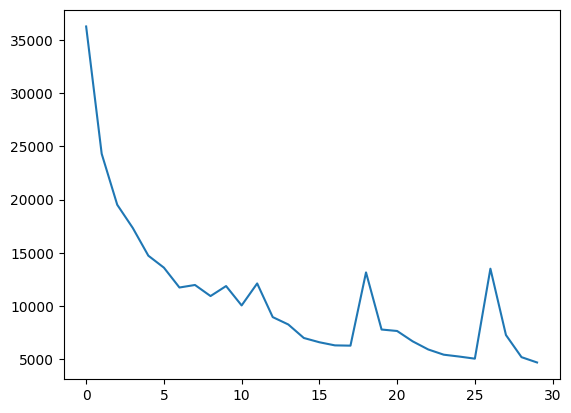

In [14]:
plt.plot(training_loss)

In [15]:
model_path = artifacts_path.joinpath('fcn-8s.multi-stage.pth')

In [16]:
torch.save(model.state_dict(), model_path)

In [17]:
get_file_size(model_path)

'513.05MiB'

# inference

In [11]:
backbone = fcn_style_vgg("vgg16", trainable=False, num_skip_connection=1)
model = FCN(backbone, NUM_CLASS + 1, num_skip_connection=1).to(DEVICE)

In [12]:
model_path = artifacts_path.joinpath("fcn-16s.e2e.pth").as_posix()
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

### mIOU

#### FCN-16S

In [13]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [14]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [15]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [00:18<00:00,  4.16it/s]


In [40]:
# bilinear
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.77 
bicycle        : 0.37 
bird           : 0.84 
boat           : 0.75 
bottle         : 0.72 
bus            : 0.86 
car            : 0.78 
cat            : 0.85 
chair          : 0.53 
cow            : 0.78 
diningtable    : 0.82 
dog            : 0.77 
horse          : 0.66 
motorbike      : 0.7  
person         : 0.75 
pottedplant    : 0.53 
sheep          : 0.79 
sofa           : 0.68 
train          : 0.85 
tvmonitor      : 0.76 
----------------------
total          : 0.73 


#### FCN-8S

In [22]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [23]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [24]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [00:29<00:00,  2.72it/s]


In [25]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.77 
bicycle        : 0.32 
bird           : 0.81 
boat           : 0.74 
bottle         : 0.71 
bus            : 0.87 
car            : 0.81 
cat            : 0.84 
chair          : 0.46 
cow            : 0.78 
diningtable    : 0.82 
dog            : 0.76 
horse          : 0.67 
motorbike      : 0.75 
person         : 0.75 
pottedplant    : 0.28 
sheep          : 0.8  
sofa           : 0.66 
train          : 0.85 
tvmonitor      : 0.78 
----------------------
total          : 0.71 


#### multi-stage FCN-8S

In [18]:
metric = jaccard.MulticlassJaccardIndex(NUM_CLASS + 1, average=None)

In [19]:
evaluator = ClassificationEvaluator(NUM_CLASS, DEVICE)

In [20]:
metric = evaluator.run(test_loader, model, metric)

100%|██████████| 79/79 [00:35<00:00,  2.25it/s]


In [21]:
for class_name, value in zip(VOC_CLASS_NAMES, metric.compute()[1:].mul(100).round().tolist()):
    print("{:<15}: {:<5}".format(class_name, value / 100))

print("----------------------")
print("{:<15}: {:<5}".format("total", metric.compute()[1:].mean().mul(100).round().item()/100))

aeroplane      : 0.85 
bicycle        : 0.55 
bird           : 0.88 
boat           : 0.83 
bottle         : 0.82 
bus            : 0.93 
car            : 0.88 
cat            : 0.92 
chair          : 0.69 
cow            : 0.86 
diningtable    : 0.9  
dog            : 0.88 
horse          : 0.79 
motorbike      : 0.83 
person         : 0.85 
pottedplant    : 0.62 
sheep          : 0.87 
sofa           : 0.87 
train          : 0.91 
tvmonitor      : 0.87 
----------------------
total          : 0.83 


### for image in dataset

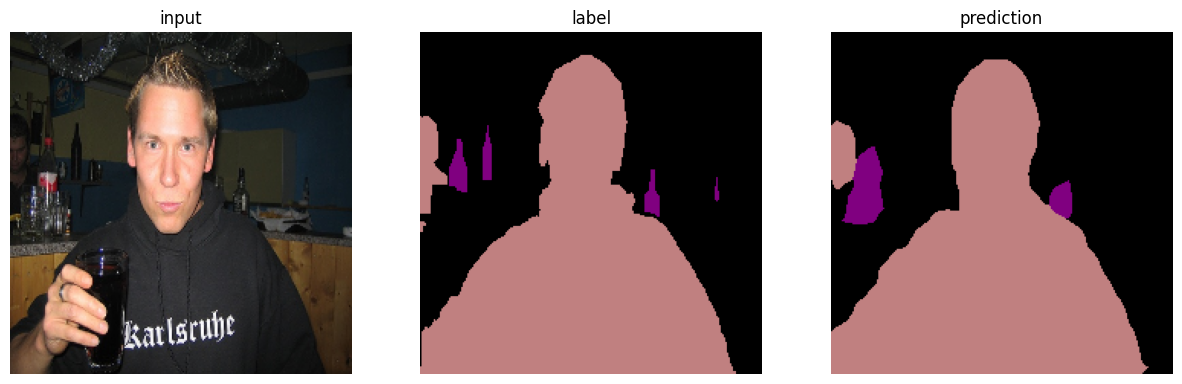

In [22]:
interest_pic = 10

model.eval()
with torch.no_grad():
    target_img, target_label = test_dataset[interest_pic]

    output = model(target_img.unsqueeze(0).to(DEVICE))
    output = output.squeeze(0).permute(1, 2, 0).argmax(dim=2).detach().cpu()

plot_grids(
    [
        img_tensor_to_np(target_img),
        decode_segmap(target_label.numpy(), LABEL_COLORS),
        decode_segmap(output.numpy(), LABEL_COLORS),
    ],
    ["input", "label", "prediction"],
    1,
    3,
    figsize=(15, 15),
)

### for any image

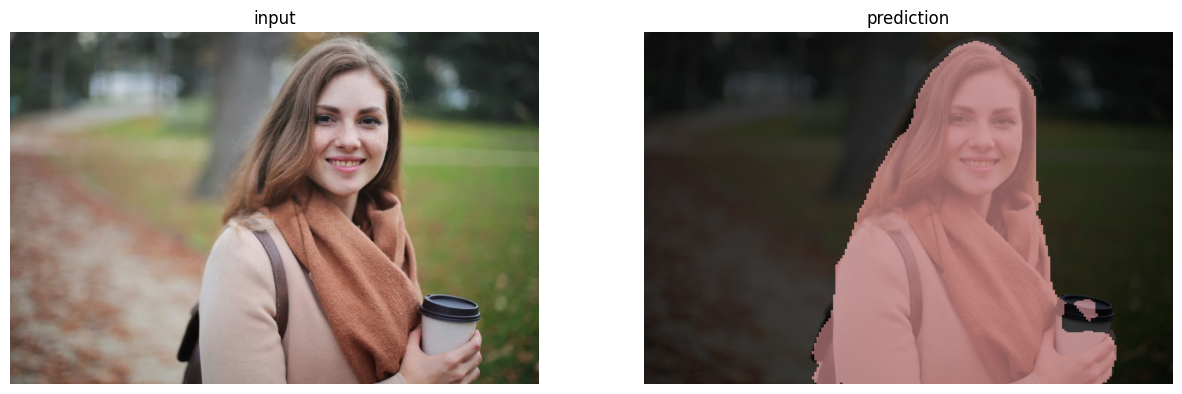

In [23]:
model.eval()
with torch.no_grad():
    target_img = load_image(data_path.joinpath("person.webp"), is_numpy=True)

    h, w, c = target_img.shape
    test_img = test_preprocess(image=target_img)["image"]
    output = model(test_img.unsqueeze(0).to(DEVICE))
    output = output.argmax(dim=1, keepdim=True)
    # B, C, H, W
    output = F.interpolate(output.float(), size=(h, w), mode="nearest")
    # 1, 1, h, w
    output = output.squeeze(0, 1).detach().cpu().numpy()

    coef = 0.7
    mask = decode_segmap(output, LABEL_COLORS)
    overlay_image = target_img.copy()
    for channel_idx in range(c):
        overlay_image[: , : ,channel_idx] = overlay_image[: , : ,channel_idx] * (1 - coef) + mask[: , : ,channel_idx] * coef


    plot_grids(
        [
            target_img,
            overlay_image,
        ],
        ["input", "prediction"],
        1,
        2,
        figsize=(15, 15),
    )